[Link to colab](https://colab.research.google.com/github/lsmin0152/cheb301/blob/main/notebooks/CHEB301_F25_14_Classification.ipynb)

## **Classification examples**

# **Practice with SVM**
In this notebook, we will explore the `scikit-learn` implementations of support vector machines (a class ML technique). This algorithm is the most often applied for classification problems, although there are ways to pivot towards regression. Let's see how they work!

In [1]:
# modules needed for this notebook
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

## **Support Vector Machines**

Support vector machines are an "older" technique, developed in the 90's based on statistical learning theory. They are capable of both performing linear classification, in which the classification of a sample is based on some linear combination of its characteristics, as well as non-linear classification. In terms of how an SVM functions, you can think of the task as trying to find a hyperplane in the feature space that maximally partitions the data; the objective is to find the splitting that maximizes distance of the classes to this high-dimensional surface.

Run the cells below to explore how the complexity of the hyperplane and classification task impacts results. For simplicity, we will just be using a packaged `iris` dataset from `sklearn`, which relates to the taxonomy of flowers. I guess that is kind of science/engineering...

### 1. Simple Linear SVC and Decision Boundary

Study and run the cell below and examine what happens when using a linear decision boundary.

You may add additional lines to ascertain how many samples are in your dataset/training/test split.

***Note:*** Notice how we are using the standard scaler. Very importantly, when we fit the transform, we are only doing so over our *training* data. It is a subtle problem, but fitting over the whole dataset is bad practice that is prone to "data leakage" and bias.

In [2]:
# load the iris dataset
iris = datasets.load_iris()
X = iris.data[:100, :2] # take only the first two features
# sepal length and width
y = iris.target[:100]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create and train a linear SVM model
clf = SVC(kernel="linear", C=1) # vary C, see impact
clf.fit(X_train, y_train)

# prediction on the test set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


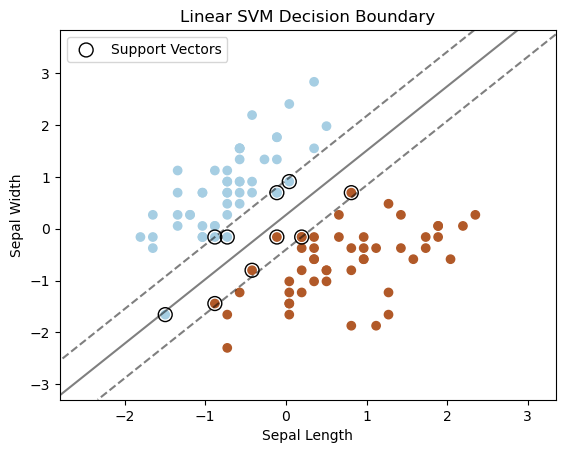

In [3]:
# plot the decision boundary
fig, ax = plt.subplots()

X_std = scaler.transform(X)
ax.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.Paired)

# create grid to evaluate model
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

xy = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5, linestyles=["--", "-", "--"])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=100, facecolors="none", edgecolors="k", label="Support Vectors")

ax.legend(loc="upper left")
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_title("Linear SVM Decision Boundary")
plt.show();

### 2. SVC with Non-linear Kernels

The linear decision boundary does a pretty good job already. If we elect to use a non-linear boundary, we then have additional decisions to make. These decisions manifest in the selection of a kernel, which supplies a transformation on our feature space. We will explore several different kernels and examine their differences.

Furthermore, using the non-linear separation approach implies that hard-margin will fail. Therefore, our loss function now includes so called slack variables, and this inclusion necessitates the existence of a hyperparameter $C$ that will impact how important we consider this to be. We will show how $C$ affects the results.

In [4]:
# load the iris dataset
iris = datasets.load_iris()
X = iris.data[:100, :2] # take only the first two features
# sepal length and width
y = iris.target[:100]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_std = scaler.transform(X)

In [5]:
# define a function to plot svc decision boundary
def plot_svc_boundary(X_train, y_train, X_test, y_test, kernel, C=1, degree=3):
    clf = SVC(kernel=kernel, C=C, degree=degree)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.Paired)

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    xy = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.decision_function(xy).reshape(xx.shape)

    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
            alpha=0.5, linestyles=["--", "-", "--"])

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, facecolors="none", edgecolors="k", label="Support Vectors")

    ax.legend(loc="upper left")
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.set_title(f"Kernel: {kernel} C: {C} Accuracy: {acc*100:0.2f}%")
    plt.show();

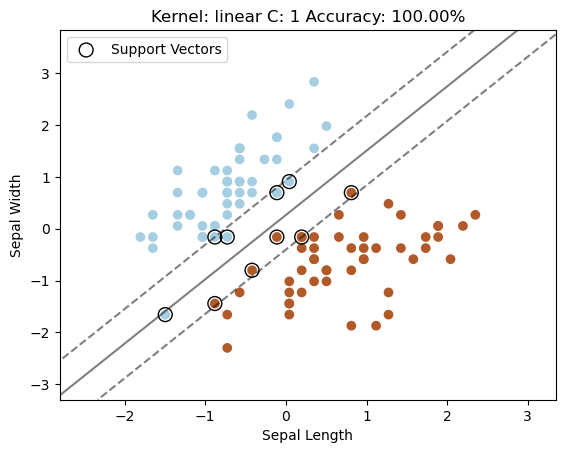

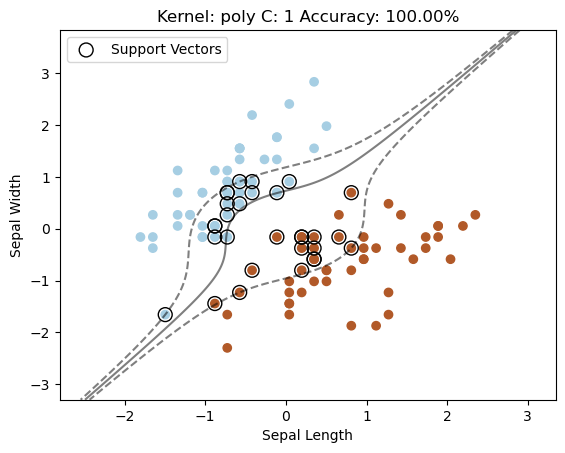

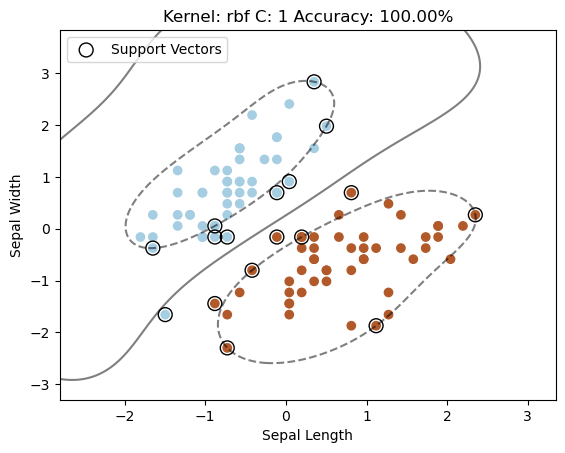

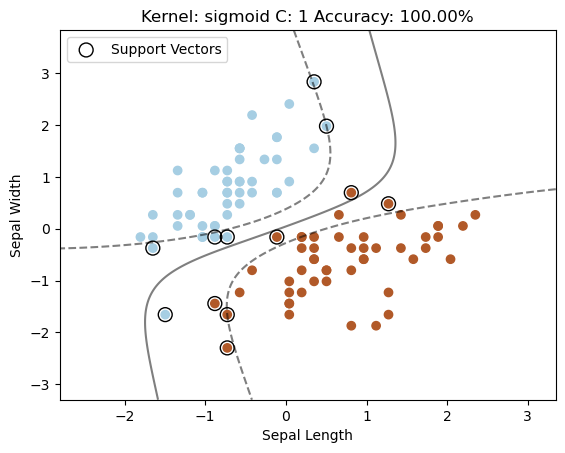

In [6]:
# plot svc with different kernels
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    plot_svc_boundary(X_train, y_train, X_test, y_test, kernel=kernel, C=1)

### 3. SVC Hyperparameter Tuning

To find the best set of hyperparameters for our problem, we often engage in so-called hyperparameter optimization or tuning. A common way to approach this (for tractable model space and dataset size) is to simply perform a grid-search and evaluate all possible models on the grid. The cells below illustrate this with the aid of some helpful functions that automate the implementation (which would not be hard to do on your own!).   

In [7]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# define the model
model = SVC()

# define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_C', 'param_kernel', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = SVC(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
    param_C param_kernel  mean_test_score
0       0.1       linear         0.775000
1       0.1          rbf         0.716667
2       0.1         poly         0.650000
3       0.1      sigmoid         0.783333
4       1.0       linear         0.766667
5       1.0          rbf         0.766667
6       1.0         poly         0.675000
7       1.0      sigmoid         0.783333
8      10.0       linear         0.775000
9      10.0          rbf         0.741667
10     10.0         poly         0.716667
11     10.0      sigmoid         0.691667
12    100.0       linear         0.775000
13    100.0          rbf         0.725000
14    100.0         poly         0.725000
15    100.0      sigmoid         0.675000

Best Hyperparameters: {'C': 0.1, 'kernel': 'sigmoid'}
Test Accuracy with Best Hyperparameters: 0.9333333333333333
